<a href="https://colab.research.google.com/github/BlueBug12/stock/blob/master/bin/cloud/CNN_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 23kB/s 
     |████████████████████████████████| 3.0MB 47.5MB/s 
     |████████████████████████████████| 460kB 50.0MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [3]:
!nvidia-smi

Mon Nov 16 14:20:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv1D, Dense, Activation,MaxPooling1D, GlobalAveragePooling1D, Dropout, Lambda, RepeatVector, Input, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import tensorflow
import matplotlib.pyplot as plt
import pickle
import os
import pandas
import math

In [5]:
print(tensorflow.__version__)

2.2.0


In [6]:
def buildYTrain(train, pastDay, futureDay,profit):
    Y_train = []
    for i in range(train.shape[0]-futureDay-pastDay):
        ave = np.mean(train['high'][i+pastDay+1:i+pastDay+futureDay])
        #if train['close'][i+pastDay] > train['close'][i+pastDay-1]:
        #    Y_train.append(1)
        #else:
        #    Y_train.append(0)

        if (ave-train['close'][i+pastDay])/ train['close'][i+pastDay] > profit:
            Y_train.append(0)
        #elif (ave-train['close'][i+pastDay])/ train['close'][i+pastDay] < -profit:
        #    Y_train.append(1)
        else:
            Y_train.append(1)     
    return np.array(Y_train)

def buildXTrain(train, pastDay, futureDay,profit):
    X_train = []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train[i:i+pastDay]))
    return np.array(X_train)

def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    minmaxscaler = scaler.fit(data)
    normalize_data = minmaxscaler.transform(data)

    return normalize_data
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]
def training_result(history):
    plt.title('Model loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('Losss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [53]:
from google.colab import files
uploaded = files.upload()

Saving 2603.pickle to 2603.pickle


In [55]:
!mv 2603.pickle data/

In [9]:
!mkdir data
!mv 2330.pickle data/

In [133]:
with open(os.path.join(os.getcwd(),"data","2603.pickle"),'rb') as f:
    df = pickle.load(f)
    print(df.tail())
    print(df.shape)
    df.drop(['year','week','month','day','adj_close'],axis=1,inplace=True)
    
    '''
    df = df[['open','high','low','close','volume']]
    '''
    df['diff1'] = df['close']-df['open']
    df['diff2']= df['close']-df['low']
    df['diff3']= df['high']-df['close']
    df['diff4']= df['high']-df['low']
    df['diff5']= df['open']-df['low']
    df['diff5']= df['high']-df['open']

    
    

    

      adj_close  close   high    low  ...     ema_D        RS        RSI       OBV
4097      21.65  21.70  22.05  20.65  ...  0.054850  7.439919  88.151545  0.750000
4098      19.95  19.95  22.20  19.55  ...  0.280870  1.259192  55.736383  0.150943
4099      20.15  20.20  20.45  19.05  ...  0.243421  1.396129  58.266018  0.821429
4100      19.50  19.50  20.30  19.20  ...  0.304298  0.967913  49.184733  0.272727
4101      20.05  20.10  20.90  19.80  ...  0.263725  1.271259  55.971555  0.272727

[5 rows x 36 columns]
(4102, 36)


In [134]:
past = 100
future = 5
profit = 0.05
val_ratio = 0.2

data_y = buildYTrain(df.copy(),past,future,profit)

#df = df.copy().drop(['open','high','low','close'],axis=1)
df = df.copy()
data = normalize_data(df.copy())

data_x = buildXTrain(data,past,future,profit)
print(data_x.shape)
print(data_y.shape)



(3997, 100, 36)
(3997,)


In [135]:
data_X, data_Y = shuffle(data_x, data_y)
x_train, y_train, x_val, y_val = splitData(data_X, data_Y, val_ratio)
test_x = x_train[-60:]
x_train = x_train[:-60]
test_y = y_train[-60:]
y_train = y_train[:-60]
#Y_train = to_categorical(y_train, num_classes=num_classes)
#Y_val = to_categorical(y_val, num_classes=num_classes)

In [136]:
backend.clear_session()

model = Sequential()
model.add(Conv1D(32, 3, activation='selu', input_shape=(x_train.shape[1:])))
model.add(Conv1D(32, 3, activation='selu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='selu'))
model.add(Conv1D(32, 3, activation='selu'))
model.add(MaxPooling1D(2))

model.add(Conv1D(32, 3, activation='selu'))
model.add(Conv1D(32, 3, activation='selu'))
model.add(MaxPooling1D(2))

model.add(Conv1D(32, 3, activation='selu'))
model.add(Conv1D(32, 3, activation='selu'))
model.add(MaxPooling1D(2))


#model.add(Conv1D(128, 3, activation='selu'))
#model.add(Conv1D(128, 3, activation='selu'))

#model.add(Conv1D(160, 3, activation='selu'))
model.add(GlobalAveragePooling1D())
#model.add(Dropout(0.5))
#model.add(Flatten())
model.add(Dense(512, activation='selu'))    
model.add(Dropout(0.5))    
model.add(Dense(512, activation='selu'))    
model.add(Dropout(0.5)) 
#model.add(Dense(num_classes, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 98, 32)            3488      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 32)            3104      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 44, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 22, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 20, 32)            3

Epoch 1/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.4591 - accuracy: 0.8757 - val_loss: 0.3091 - val_accuracy: 0.9074
Epoch 2/1000
99/99 [==============================] - 1s 7ms/step - loss: 0.3749 - accuracy: 0.8955 - val_loss: 0.4364 - val_accuracy: 0.8949
Epoch 3/1000
99/99 [==============================] - 1s 7ms/step - loss: 0.3812 - accuracy: 0.8917 - val_loss: 0.3035 - val_accuracy: 0.9074
Epoch 4/1000
99/99 [==============================] - 1s 7ms/step - loss: 0.3436 - accuracy: 0.8993 - val_loss: 0.3243 - val_accuracy: 0.9074
Epoch 5/1000
99/99 [==============================] - 1s 7ms/step - loss: 0.3313 - accuracy: 0.9025 - val_loss: 0.3387 - val_accuracy: 0.9074
Epoch 6/1000
99/99 [==============================] - 1s 7ms/step - loss: 0.3275 - accuracy: 0.9028 - val_loss: 0.3255 - val_accuracy: 0.9074
Epoch 7/1000
99/99 [==============================] - 1s 7ms/step - loss: 0.3204 - accuracy: 0.9034 - val_loss: 0.3178 - val_accuracy: 0.9074
Epoch

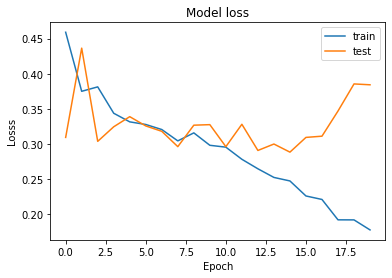

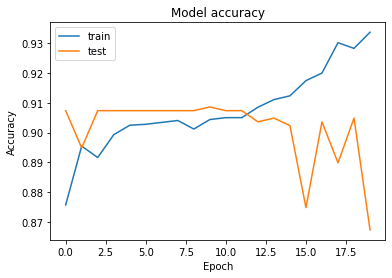

In [137]:
callback = EarlyStopping(monitor="val_accuracy", patience=10, verbose=1, mode="auto")
history=model.fit(x_train, y_train, epochs=1000, batch_size=32, validation_data=(x_val, y_val), callbacks=[callback])
training_result(history)

In [138]:
ans=model.predict(test_x)
TP = 0
FP = 0
TN = 0
FN = 0

for i in range(len(test_y)):
  if (ans[i]>=0.5 and test_y[i]>0.5):
    TP += 1
  elif (ans[i]>=0.5 and test_y[i]<0.5):
    FP += 1
  elif (ans[i]<0.5 and test_y[i]>0.5):
    FN += 1
  else:
    TN += 1
    
print(f'TP:{TP}',f'FP:{FP}',f'TN:{TN}',f'FN:{FN}')
print(TP/(TP+FP))
print('')

TP:48 FP:11 TN:0 FN:1
0.8135593220338984



TP:4 FP:28 TN:21 FN:7
0.125

